# Advection Diffusion, HW2
## From Tony Saad's uCFD Course at University of Utah
### Completed by Matt Williams (matt.williams@alum.mit.edu)
</hr>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['animation.html'] = 'html5'

# Problem 1
## Implicit solution to the advection-diffusion equation
1. Show the discrete solution to the advection-diffusion equation using an Euler scheme for time and a centered scheme for space.

The advection equation is:

$$\frac{\partial u}{\partial t} = -c\frac{\partial u}{\partial x}$$

Discretizing as described above gives:

$$\frac{u^{n+1}_i-u^n_i}{\Delta t} = -c\frac{u^{n+1}_{i+1}-u^{n+1}_{i-1}}{2\Delta x}$$

Rearranging gives:

$$u^{n+1}_i + \frac{c\Delta t}{2\Delta x}\left( u^{n+1}_{i+1} - u^{n+1}_{i-1} \right) = u^n_i$$

Here, if we let $B = \frac{c\Delta t}{2\Delta x}$, then the system of equations to solve is $Au^{n+1}_i = u^n_i$, where $A$ is a tridiagonal matrix whose entries are $-B$, $1$, and $B$.

The boundary conditions are defined by the first and last rows. We must implement the periodic boundary conditions in the first and last rows where we do not have a $u_{i-1}$ or $u_{i+1}$ term respectively. 

For the first row, $u_{i-1} = u_{-2}$, and for the last row $u_{i+1}=u_1$. Then, for the final row, we will impose the condition that $u_{-1}=u_{0}$.

The initial condition is $u_0=e^{-\left({\frac{x-x_0}{\sigma}}\right)^2}$. Let's examine it on the domain $[0,1]$.

In [3]:
n = [21, 41, 81, 161]
dx = []
x = []
u0 = []
L = 1.
x0 = 0.3
σ = 0.1
for n_ in n:
    d = L/(n_-1)
    dx.append(d)
    x_ = np.linspace(0, L, n_)
    x.append(x_)
    u = np.exp(-((x_-x0)/σ)**2)
    u0.append(u)

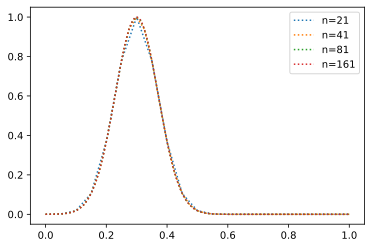

In [4]:
i = 0
for x_, sol in zip(x, u0):
    plt.plot(x_, sol, ':', label=f'n={n[i]}')
    i+=1
plt.legend()

In [5]:
tend = 0.5
dt = 1e-3
c = 1.
A = []
u_ex = []
for dx_, nx, x_ in zip(dx, n, x): 
    cfl = c*dt/2./dx_
    A_ = np.zeros((nx, nx))
    for i in range(1,nx-1):
        A_[i, i-1] = -cfl
        A_[i, i] = 1
        A_[i, i+1] = cfl
    A_[0,0] = 1
    A_[0,1] = cfl
    A_[0,-2] = -cfl
    A_[-1,-2] = -cfl
    A_[-1,-1] = 1
    A_[-1,1] = cfl
    A.append(A_)
    u_exact = np.exp(-((x_-c*tend-x0)/σ)**2)
    u_ex.append(u_exact)

In [6]:
u_sol = []
for i in range(len(n)):
    un = u0[i]
    t = 0
    while t < tend:
        unew = np.linalg.solve(A[i], un)
        unew[0] = un[-1]
        un = np.copy(unew)
        t += dt
    u_sol.append(unew)

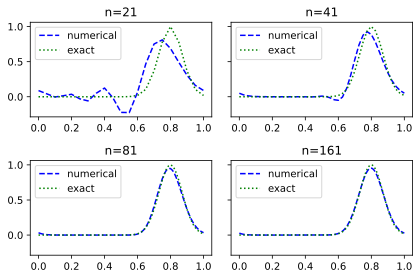

In [7]:
fig, ax = plt.subplots(2,2, sharey=True)
counter = 0
for i in range(2):
    for j in range(2):
        ax[i][j].plot(x[counter], u_sol[counter], 'b--',label='numerical')
        ax[i][j].plot(x[counter], u_ex[counter], 'g:',label='exact')
        ax[i][j].set_title(f'n={n[counter]}')
        ax[i][j].legend()
        counter += 1
plt.tight_layout()

3. Plot the error of the numerical solution

In [8]:
error = []
l2 = []
for approx, exact, dx_ in zip(u_sol, u_ex, dx):
    err = np.abs(approx - exact)
    l2_err = np.sqrt(dx_)*np.linalg.norm(err, 2)
    error.append(err)
    l2.append(l2_err)

In [9]:
l2

[0.1744768655354863,
 0.06369691443233486,
 0.02217798601290887,
 0.015345855424636507]

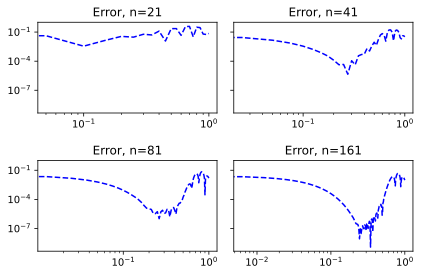

In [10]:
fig, ax = plt.subplots(2,2, sharey=True)
counter = 0
for i in range(2):
    for j in range(2):
        ax[i][j].loglog(x[counter], error[counter], 'b--')
        ax[i][j].set_title(f'Error, n={n[counter]}')
        counter += 1
plt.tight_layout()

In [11]:
for idx, err in enumerate(error):
    maxerr = np.max(err)
    print(f'Max error for n={n[idx]}: {maxerr}')

Max error for n=21: 0.38332788507045756
Max error for n=41: 0.167524393581859
Max error for n=81: 0.069549740965133
Max error for n=161: 0.04857843018010655


4. Determine the maximum time step from Von Neuman stability analysis.

Von Neumann stability requires the ratio of coefficients of the time-marching solution to be less than 1. First, assume a PDE solution of $u = A(t)e^{jkx}$, where $j=\sqrt{-1}$. Insert it into the numerical advection equation to get:
$$u^{n+1}_i + \frac{c\Delta t}{2\Delta x}\left( u^{n+1}_{i+1} - u^{n+1}_{i-1} \right) = u^n_i$$


$$A^{n+1}e^{jki} + \frac{c\Delta t}{2\Delta x}\left(A^{n+1}e^{jk(i+1)}-A^{n+1}e^{jk(i-1)}\right) = A^ne^{jki}$$

## Adjusting answer starting here

Now, if we allow $\xi = \frac{A^{n+1}e^{jki}}{A^{n}e^{jki}}$ and divide the entire equation by $A^{n}e^{jki}$

$$\xi + \frac{c\Delta t}{2\Delta x}\left(\xi e^{jk}-\xi e^{-jk}\right) = 1$$

$$\xi = \frac{1}{1+ \frac{c\Delta t}{2\Delta x}\left(e^{jk}-e^{-jk}\right)}$$

The term in parenthesis is equal to $isin(k)$, therefore:

$$\xi = \frac{1}{1+ \frac{c\Delta t}{2\Delta x}jsin(k)}$$

Muliplying the top and bottom by the complex conjugate: 

$$\xi = \frac{1-\frac{c\Delta t}{2\Delta x}jsin(k)}{1+ \left(\frac{c\Delta t}{2\Delta x}\right)^2sin^2(k)}$$

Taking the magnitude of $\xi$, we get:

$$|\xi|^{2} = \frac{1+\left(\frac{c\Delta t}{2\Delta x}\right)^2}{\left(1+\left(\frac{c\Delta t}{2\Delta x}\right)^2 \right)^2}$$

Which is always less than or equal to 1, because creating an inequality with the numerator and denominator results in:

$$1 \leq 2 + \left(\frac{c\Delta t}{2\Delta x}\right)^2 sin^2(k)$$

which is always satisfied for any values of $\Delta t$ and $\Delta x$.

# Problem 3

Implement a Python code to solve the 2D advection-diffusion equation:

$$\frac{\partial u}{\partial t} = -\textbf{c}\nabla u + \mu\nabla ^2u$$

on the domain $[1,1]$, taking $\mu = 0.1$ and a grid spacing of $(nx, ny) = (41, 41)$. The advecting velocities in the constant vector $\textbf{c}$ are $sin(2\pi)$.

In [42]:
# Set up physical problem
nx = 41
ny = 41
Lx = 1.
Ly = 1.
dx = Lx/(nx-1)
dy = Ly/(ny-1)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
ω1 = 2*np.pi
ω2 = 2*np.pi
μ = 1e-1

In [43]:
u0 = lambda x, y: np.sin(ω1*x)*np.sin(ω2*y)
xx, yy = np.meshgrid(x, y)

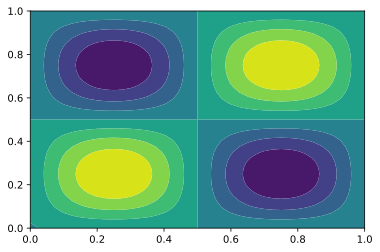

In [44]:
plt.contourf(xx, yy, u0(xx,yy))

In [45]:
tend = 0.5
dt = 1e-3
c1 = 1.
c2 = 1.
cfl1 = c1*dt/dx
cfl2 = c2*dt/dy

sol = []
u = np.zeros((nx+2, ny+2))
u[1:-1,1:-1] = u0(xx,yy)
# Set periodic boundary conditions
u[:,0] = u[:,-3]
u[:,-1] = u[:,2]
u[0,:] = u[-3,:]
u[-1,:] = u[2,:]
sol.append(u)

In [46]:
t = 0.
while t < tend:
    un = sol[-1]
    unew = np.copy(un)
    unew[1:-1,1:-1] = un[1:-1,1:-1] - cfl1*(un[1:-1,1:-1]-un[1:-1,:-2]) - cfl2*(un[1:-1,1:-1]-un[:-2,1:-1]) + \
                      μ*dt/dx**2*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,:-2]) + \
                      μ*dt/dy**2*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[:-2,1:-1])
    unew[:,0] = unew[:,-3]
    unew[:,-1] = unew[:,2]
    unew[0,:] = unew[-3,:]
    unew[-1,:] = unew[2,:]
    sol.append(unew)
    t += dt

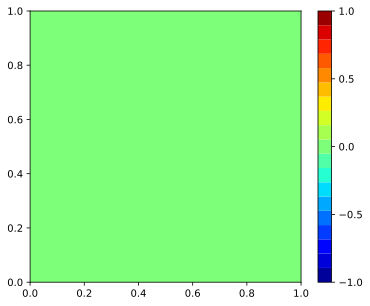

In [47]:
ims = []
fig = plt.figure(figsize=(6.1,5), facecolor='w')
levs = np.linspace(-1,1,20)
t = 0.0
i = 0
for solution in sol:
    if (i%5==0): # output frequency for frames  
        im = plt.contourf(xx,yy,solution[1:-1,1:-1],cmap=cm.jet, levels=levs,vmax=1.,vmin=-1.)
        ims.append(im.collections)
    i+=1
    t += dt

cbar = plt.colorbar()
plt.clim(-1,1)
cbar.set_ticks(np.linspace(-1,1,5))
ani = animation.ArtistAnimation(fig, ims, interval=35, blit=True,
                                repeat_delay=1000)
# ani.save('ftus.mp4')   
ani

In [25]:
unew

array([[-4.55803749e-11,  3.65170515e-17,  4.55804479e-11, ...,
        -4.55803749e-11,  3.65170514e-17,  4.55804479e-11],
       [-1.98597764e-11,  3.65170515e-17,  1.98598494e-11, ...,
        -1.98597764e-11,  3.65170514e-17,  1.98598494e-11],
       [ 6.34983669e-12,  3.65170515e-17, -6.34976366e-12, ...,
         6.34983669e-12,  3.65170515e-17, -6.34976366e-12],
       ...,
       [-4.55803749e-11,  3.65170515e-17,  4.55804479e-11, ...,
        -4.55803749e-11,  3.65170514e-17,  4.55804479e-11],
       [-1.98597764e-11,  3.65170515e-17,  1.98598494e-11, ...,
        -1.98597764e-11,  3.65170514e-17,  1.98598494e-11],
       [ 6.34983669e-12,  3.65170515e-17, -6.34976366e-12, ...,
         6.34983669e-12,  3.65170515e-17, -6.34976366e-12]])